In [1]:
#COOL DATA STUFF
#print('hello world')

In [1]:

import pandas as pd
import pickle
import numpy as np

In [4]:
df_co2 = pd.read_csv("CO2 Emissions_Canada.csv")

In [13]:
#df_co2[(df_co2['Make'] == 'ACURA')&(df_co2['Model'] == 'ILX') ]

In [5]:
vals = pd.DataFrame(df_co2['Cylinders'].value_counts())
vals = vals.index.tolist()
file = 'cylinders.pickle'
openFile = open(file, 'wb')
pickle.dump(vals, openFile)
openFile.close()

In [7]:
vals = pd.DataFrame(df_co2['Make'].value_counts())
vals.head()
vals = vals.index.tolist()

file = "makes.pickle"
openFile = open(file, 'wb')
pickle.dump(vals, openFile)
openFile.close()

In [8]:
vals = pd.DataFrame(df_co2['Model'].value_counts())
vals.head()
vals = vals.index.tolist()

file = "models.pickle"
openFile = open(file, 'wb')
pickle.dump(vals, openFile)
openFile.close()

In [51]:
model_dict = dict()
for i in vals:
    models = pd.DataFrame(df_co2[df_co2['Make'] == i]['Model'].value_counts())
    models = models.index.tolist()
    model_dict[i] = models
#print(model_dict)

file = "models.pickle"
openFile = open(file, 'wb')
pickle.dump(model_dict, openFile)
openFile.close()

In [9]:
ourDict = pickle.load(open('models.pickle','rb'))
ourDict

['F-150 FFV 4X4',
 'F-150 FFV',
 'MUSTANG',
 'FOCUS FFV',
 'SONIC',
 'SONIC 5',
 'F-150 4X4',
 'F-150',
 'ACCORD',
 'COMPASS',
 'JETTA',
 'ATS',
 'TACOMA 4WD',
 'CAMARO',
 'SIERRA',
 'COROLLA',
 'SIERRA 4WD',
 'SILVERADO 4WD',
 'SILVERADO',
 'FORTE 5',
 'PATRIOT',
 'FORTE KOUP',
 'FUSION',
 'CHARGER FFV',
 'FRONTIER',
 'COLORADO',
 'SOUL',
 'PASSAT',
 'FORESTER AWD',
 'BEETLE',
 'CANYON',
 'OUTBACK AWD',
 'BRZ',
 'CRUZE',
 'ELANTRA',
 'FORTE',
 'FIT',
 'CHALLENGER',
 'CX-5',
 'LEGACY AWD',
 'EDGE AWD',
 'MAZDA3 4-DOOR',
 'SILVERADO 4WD FFV',
 'SIERRA FFV',
 'SIERRA 4WD FFV',
 'ESCAPE',
 'SILVERADO FFV',
 '200 FFV',
 'EQUINOX AWD',
 'TERRAIN AWD',
 '300 AWD FFV',
 'CHARGER (MDS)',
 'TACOMA',
 'MUSTANG CONVERTIBLE',
 'Silverado 4WD',
 'ELANTRA GT',
 '370Z',
 'Sierra 4WD',
 'RVR',
 'LANCER',
 'Q70 AWD',
 'SORENTO AWD',
 'COMPASS 4X4',
 'CT6 AWD',
 'F-150 (LT Tire Pkg)',
 'EQUINOX',
 'CANYON 4WD',
 'COLORADO 4WD',
 'G80 AWD',
 'A8L',
 'MAZDA3 5-DOOR',
 'MX-5',
 'RVR 4WD',
 'Q50 AWD',
 'TER

In [11]:
def find_co2_emis(df_co2, make, model, cylinder, transmission):
    make = make.upper()
    model = model.upper()
    transmission = transmission.lower()
    if len(df_co2[(df_co2['Make'] == make)&(df_co2['Model'] == model) ]) < 1:
        print("Car not found please enter average fuel consumption")
        return
    elif len(df_co2[(df_co2['Make'] == make)&(df_co2['Model'] == model) ]) == 1:
        return df_co2[(df_co2['Make'] == make)&(df_co2['Model'] == model) ]['CO2 Emissions(g/km)']
    else:
        #avg them, or also request cylinder and transmission type to make it even more specific.
        #return df_co2[(df_co2['Make'] == make)&(df_co2['Model'] == model) ]['CO2 Emissions(g/km)'].mean()
        subset = df_co2[(df_co2['Make'] == make)&(df_co2['Model'] == model) &(df_co2['Cylinders'] == cylinder)]
        if transmission == 'automatic':
            return subset[subset['Transmission'].str.match("A")]['CO2 Emissions(g/km)'].mean()
        else:
            return subset[subset['Transmission'].str.match("M")]['CO2 Emissions(g/km)'].mean()
        

In [13]:
find_co2_emis(df_co2, 'ACURA', 'ILX', 4, 'manual')

217.5

In [63]:
from sklearn.linear_model import LinearRegression

In [78]:
def predict_emissions(df_co2, fuelType, fuelCombo, cylinders, transmission):
    emissions = df_co2['CO2 Emissions(g/km)']
    fuelTypes =['diesel', 'ethanol', 'natural gas', 'regular', 'premium']
    adj_df = df_co2.copy()
    encodedType = pd.get_dummies(adj_df['Fuel Type'])
    adj_df.drop(['Model','Make','Vehicle Class','Fuel Type', 'CO2 Emissions(g/km)'], axis  = 1, inplace = True)
    adj_df = adj_df.join(encodedType)
    adj_df['Transmission'] = (adj_df['Transmission'].str.match("A").astype(int))
    if transmission == 'automatic':
      transmission = 1
    else:
      transmission = 0
    fuelCity = fuelCombo*2*0.55
    fuelHwy = fuelCombo*2*0.45
    engSize = df_co2[df_co2['Cylinders'] == cylinders]['Engine Size(L)'].mean()
    fuelMPG = int(282.481/fuelCombo)
    ourSerList = [engSize, cylinders,transmission, fuelCity,fuelHwy, fuelCombo, fuelMPG]
    for i in fuelTypes:
      if fuelType == i:
        ourSerList.append(1)
      else:
        ourSerList.append(0)
    ourSer = pd.Series(ourSerList)
    emissions = np.array(emissions)
    emissions = emissions.reshape(-1,1)
    samp = np.array(ourSer)
    samp = [samp]
    linReg = LinearRegression()
    linReg = linReg.fit(X = np.array(adj_df),y = emissions )
    pred = linReg.predict(samp)
    
    return pred[0][0]



In [79]:
pred = predict_emissions(df_co2, 'premium', 11.1, 6, 'automatic')
pred

261.5879075554283

In [ ]:
df_co2

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


In [ ]:
def weekly_emissions( kilometers, days, car_emissions):
    weekly = car_emissions*kilometers*days
    return weekly

In [3]:
import matplotlib.pyplot as plt

In [26]:
def graph(weekly):
    amt_weeks_match_tree = 60000/weekly
    x_axis = np.arange(0,amt_weeks_match_tree+4)
    y_axis = []
    for i in x_axis:
        y_axis.append(weekly*i)


    plt.plot( x_axis, y_axis    , "-.")
    plt.plot(amt_weeks_match_tree, weekly*amt_weeks_match_tree,"*r")
    plt.xlabel("Weeks")
    plt.ylabel("Carbon Emissions (g/km)")
    plt.title("Amount of Carbon Emissions per Week")
    plt.legend(['Carbon Emissions','Weeks to Match the Impact of a Planted Tree\n Over 10 yrs'])
    return

10.309278350515465
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


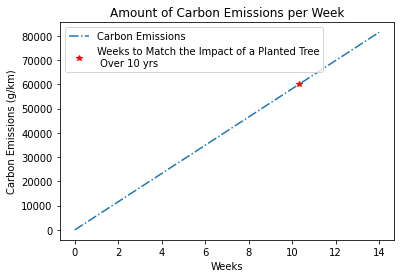

In [27]:
graph(194*10*3)